In [97]:

batch_size = 32
learning_rate = 0.001
training_steps = 5000
eval_frequency = 100
random_seed = 42
# FLAGS = flags.FLAGS

# flags.DEFINE_integer("batch_size", 128, "Size of the batch to train on.")
# flags.DEFINE_float("learning_rate", 0.001, "Learning rate for the optimizer.")
# flags.DEFINE_integer("training_steps", 5000, "Number of training steps.")
# flags.DEFINE_integer("eval_frequency", 100, "How often to evaluate the model.")
# flags.DEFINE_integer("random_seed", 42, "Random seed.")



# Data_Set

In [293]:
from typing import Iterator, Mapping, NamedTuple, Sequence, Tuple
!pip install -U dm-haiku
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
from absl import app, flags, logging
#!pip install equinox
#import equinox as eqx



PRNGKey = jnp.ndarray
Batch = Mapping[str, np.ndarray]

MNIST_IMAGE_SHAPE: Sequence[int] = (28, 28, 1)


def load_dataset(split: str, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load(
        "binarized_mnist",
        split=split,
        shuffle_files=True,
        read_config=tfds.ReadConfig(shuffle_seed=random_seed),
    )
    ds = ds.shuffle(buffer_size=10 * batch_size, seed=random_seed)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))


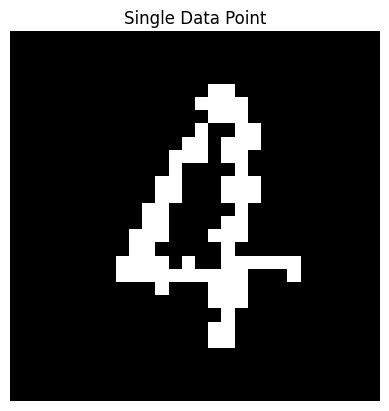

In [294]:
batch_size = 32
train_ds = load_dataset(tfds.Split.TRAIN, batch_size)
valid_ds = load_dataset(tfds.Split.TEST, batch_size)

# Get a single batch from the training dataset
batch = next(train_ds)

# Take the first data point from the batch
data_point = batch['image'][0]
import matplotlib.pyplot as plt

plt.imshow(data_point.squeeze(), cmap='gray')  # Use 'gray' for grayscale images
plt.title('Single Data Point')
plt.axis('off')
plt.show()


In [295]:
# images = batch['image']
# images_flat = images.reshape((images.shape[0], -1))
# num_pixels_to_remove = images_flat.shape[1] // 2
# missing_mask = np.zeros_like(images_flat, dtype=bool)
# for i in range(images_flat.shape[0]):
#     missing_indices = np.random.choice(images_flat.shape[1], num_pixels_to_remove, replace=False)
#     missing_mask[i, missing_indices] = True

# images_flat[missing_mask] = np.nan
# images_with_missing_data = images_flat.reshape(images.shape)

In [296]:
images = batch['image']
# Convert images to float type before introducing NaNs
images_float = images.astype(np.float32)

images_flat = images_float.reshape((images_float.shape[0], -1))  # Flatten each image

# Calculate the number of pixels to remove per image (50%)
num_pixels_to_remove = images_flat.shape[1] // 2

# Create a mask with 50% of the data points set to True (missing)
missing_mask = np.zeros_like(images_flat, dtype=bool)

for i in range(images_flat.shape[0]):
    missing_indices = np.random.choice(images_flat.shape[1], num_pixels_to_remove, replace=False)
    missing_mask[i, missing_indices] = True

# Apply the mask to create missing data
images_flat[missing_mask] = np.nan

# Reshape the data back to the original image shape
images_with_missing_data = images_flat.reshape(images_float.shape)

images_with_missing_data.shape


(32, 28, 28, 1)

In [297]:
images.shape

(32, 28, 28, 1)

In [298]:
images = batch['image']

# Convert images to float type before introducing NaNs
images_float = images.astype(np.float32)

# Directly remove the top half of each image
half_height = images_float.shape[1] // 2
images_with_top_half_missing = images_float.copy()
images_with_top_half_missing[:, :half_height, :, :] = np.nan

# No need to flatten and create a mask, so we can skip those steps

# The shape of the images_with_top_half_missing should be the same as the original batch
images_with_top_half_missing.shape

(32, 28, 28, 1)

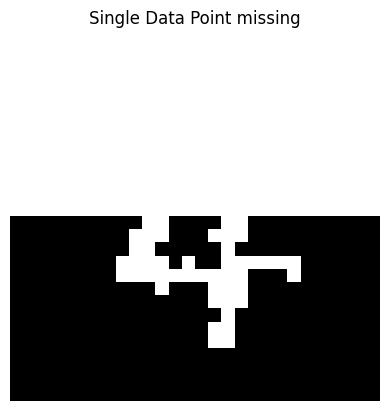

In [299]:
data_point_miss_half = images_with_top_half_missing[0]
plt.imshow(data_point_miss_half.squeeze(), cmap='gray')  # Use 'gray' for grayscale images
plt.title('Single Data Point missing')
plt.axis('off')
plt.show()

In [300]:
data_point_miss = images_with_missing_data[0]

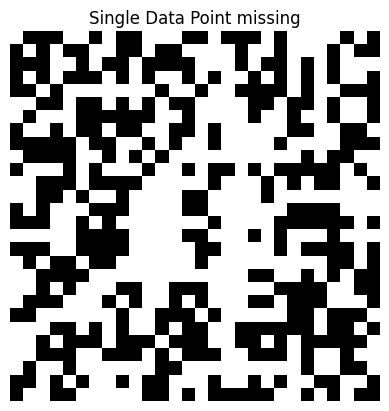

In [301]:
# Take the first data point from the batch
#data_point = batch['image'][0]

data_point_miss = images_with_missing_data[0]
plt.imshow(data_point_miss.squeeze(), cmap='gray')  # Use 'gray' for grayscale images
plt.title('Single Data Point missing')
plt.axis('off')
plt.show()

In [302]:
batch['image'][1]

array([[[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        

In [303]:
data_point.shape

(28, 28, 1)

# Model


In [304]:
class Encoder(hk.Module):
    """Encoder model."""

    def __init__(self, hidden_size: int = 512, latent_size: int = 10):
        super().__init__()
        self._hidden_size = hidden_size
        self._latent_size = latent_size

    def __call__(self, x: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
        x = hk.Flatten()(x)
        x = hk.Linear(self._hidden_size)(x)
        x = jax.nn.relu(x)

        mean = hk.Linear(self._latent_size)(x)
        log_stddev = hk.Linear(self._latent_size)(x)
        stddev = jnp.exp(log_stddev)

        return mean, stddev


class Decoder(hk.Module):
    """Decoder model."""

    def __init__(
        self,
        hidden_size: int = 512,
        output_shape: Sequence[int] = MNIST_IMAGE_SHAPE,
    ):
        super().__init__()
        self._hidden_size = hidden_size
        self._output_shape = output_shape

    def __call__(self, z: jnp.ndarray) -> jnp.ndarray:
        z = hk.Linear(self._hidden_size)(z)
        z = jax.nn.relu(z)

        logits = hk.Linear(np.prod(self._output_shape))(z)
        logits = jnp.reshape(logits, (-1, *self._output_shape))

        return logits


class VAEOutput(NamedTuple):
    image: jnp.ndarray
    mean: jnp.ndarray
    stddev: jnp.ndarray
    logits: jnp.ndarray


class VariationalAutoEncoder(hk.Module):
    """Main VAE model class, uses Encoder & Decoder under the hood."""

    def __init__(
        self,
        hidden_size: int = 512,
        latent_size: int = 10,
        output_shape: Sequence[int] = MNIST_IMAGE_SHAPE,
    ):
        super().__init__()
        self._hidden_size = hidden_size
        self._latent_size = latent_size
        self._output_shape = output_shape

    def __call__(self, x: jnp.ndarray) -> VAEOutput:
        x = x.astype(jnp.float32)
        mean, stddev = Encoder(self._hidden_size, self._latent_size)(x)
        z = mean + stddev * jax.random.normal(hk.next_rng_key(), mean.shape)
        logits = Decoder(self._hidden_size, self._output_shape)(z)

        p = jax.nn.sigmoid(logits)
        image = jax.random.bernoulli(hk.next_rng_key(), p)
        #print("recon_is:",logits)
        return VAEOutput(image, mean, stddev, logits)

In [305]:
# key = jax.random.PRNGKey(42)
# key, subkey = jax.random.split(key, 2)
# encoder = ex_encoder(key)
# decoder = ex_decoder(key)

In [306]:

def binary_cross_entropy(x: jnp.ndarray, logits: jnp.ndarray) -> jnp.ndarray:
    """Calculate binary (logistic) cross-entropy from distribution logits.

    Args:
        x: input variable tensor, must be of same shape as logits
        logits: log odds of a Bernoulli distribution, i.e. log(p/(1-p))

    Returns:
        A scalar representing binary CE for the given Bernoulli distribution.
    """
   # print("x shape is:", x[0])
    if x.shape != logits.shape:
        raise ValueError("inputs x and logits must be of the same shape")
    x = jnp.reshape(x, (x.shape[0], -1))
    #print("x reshape ? is:", x[0])
    logits = jnp.reshape(logits, (logits.shape[0], -1))
   # print("logits is:", logits)
    return -jnp.sum(x * logits - jnp.logaddexp(0.0, logits), axis=-1)
    #return -jnp.sum(jnp.logaddexp(0., jnp.where(x, -1., 1.) * logits), axis=(1,2,3))


def kl_gaussian(mean: jnp.ndarray, var: jnp.ndarray) -> jnp.ndarray:
    r"""Calculate KL divergence between given and standard gaussian distributions.

    KL(p, q) = H(p, q) - H(p) = -\int p(x)log(q(x))dx - -\int p(x)log(p(x))dx
            = 0.5 * [log(|s2|/|s1|) - 1 + tr(s1/s2) + (m1-m2)^2/s2]
            = 0.5 * [-log(|s1|) - 1 + tr(s1) + m1^2] (if m2 = 0, s2 = 1)

    Args:
        mean: mean vector of the first distribution
        var: diagonal vector of covariance matrix of the first distribution

    Returns:
        A scalar representing KL divergence of the two Gaussian distributions.
    """
    #return 0.5 * jnp.sum(-jnp.log(var) - 1.0 + var + jnp.square(mean), axis=-1)
    return -0.5 * jnp.sum(1. + jnp.log(var) - mean**2. - var, axis=1)


#FLAGS.alsologtostderr = True



In [307]:
model = hk.transform(
        lambda x: VariationalAutoEncoder()(x)
    )  # pylint: disable=unnecessary-lambda
optimizer = optax.adam(learning_rate)


In [308]:
#model = hk.transform(lambda x: VariationalAutoEncoder()(x))  # pylint: disable=unnecessary-lambda

@jax.jit
def loss_fn(params: hk.Params, rng_key: PRNGKey,batch: Batch,) -> jnp.ndarray:
  """ELBO: E_p[log(x)] - KL(d||q), where p ~ Be(0.5) and q ~ N(0,1)."""
  outputs: VAEOutput = model.apply(params, rng_key, batch["image"])
  print("batch imgL",batch["image"])
  log_likelihood = -binary_cross_entropy(batch["image"], outputs.logits)
  kl = kl_gaussian(outputs.mean, jnp.square(outputs.stddev))
  elbo = log_likelihood - kl

  return -jnp.mean(elbo)

def loss_fn2(params: hk.Params, rng_key: PRNGKey,batch: Batch,) -> jnp.ndarray:
  outputs: VAEOutput = model.apply(params, rng_key, batch["image"])
  log_likelihood = -binary_cross_entropy(batch["image"], outputs.logits)
  kl = kl_gaussian(outputs.mean, jnp.square(outputs.stddev))
  elbo = log_likelihood - kl

  return jnp.mean(log_likelihood), jnp.mean(kl)


@jax.jit
def update(
    params: hk.Params,
    rng_key: PRNGKey,
    opt_state: optax.OptState,
    batch: Batch, ) -> Tuple[hk.Params, optax.OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state



batch imgL Traced<ShapedArray(uint8[32,28,28,1])>with<DynamicJaxprTrace(level=4/0)>
STEP: 0 ELBO: -522.95044 recon_loss: -520.0488 kl: 1.1134267


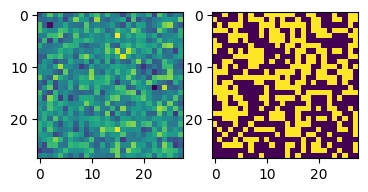

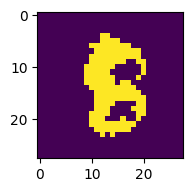

STEP: 250 ELBO: -152.78166 recon_loss: -129.46822 kl: 14.608452


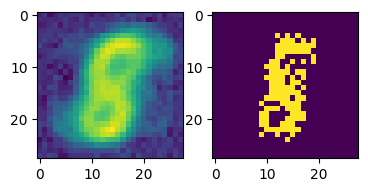

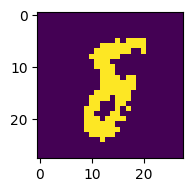

STEP: 500 ELBO: -130.45767 recon_loss: -114.324036 kl: 14.837456


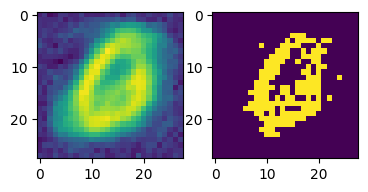

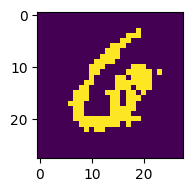

STEP: 750 ELBO: -131.86911 recon_loss: -112.75006 kl: 16.211845


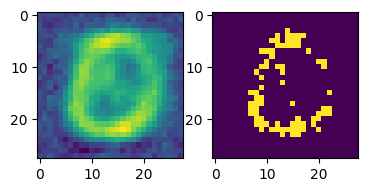

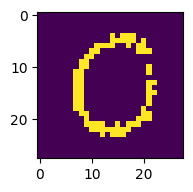

STEP: 1000 ELBO: -120.85521 recon_loss: -118.22635 kl: 17.405592


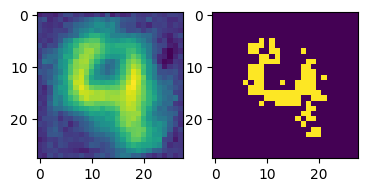

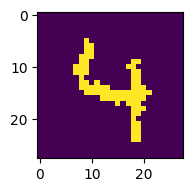

STEP: 1250 ELBO: -119.23814 recon_loss: -110.677765 kl: 16.528564


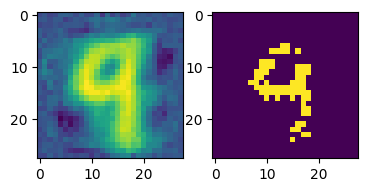

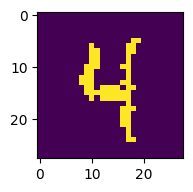

STEP: 1500 ELBO: -125.8705 recon_loss: -99.4281 kl: 16.970276


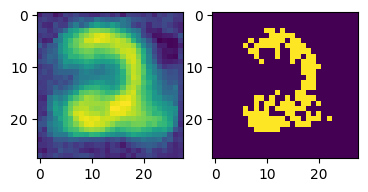

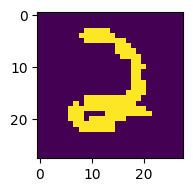

batch imgL Traced<ShapedArray(uint8[16,28,28,1])>with<DynamicJaxprTrace(level=4/0)>
STEP: 1750 ELBO: -122.87764 recon_loss: -97.438126 kl: 16.818676


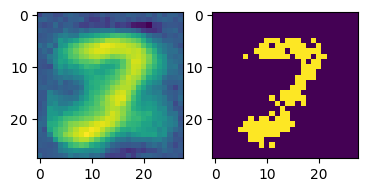

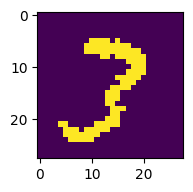

STEP: 2000 ELBO: -115.231636 recon_loss: -97.4447 kl: 16.516718


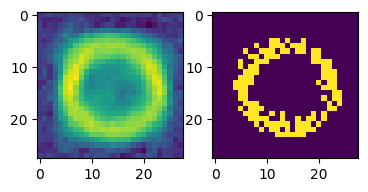

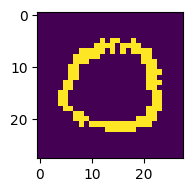

STEP: 2250 ELBO: -111.41857 recon_loss: -98.33865 kl: 17.835499


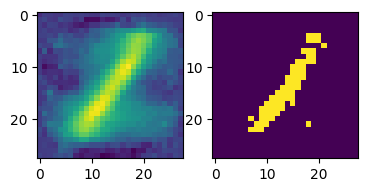

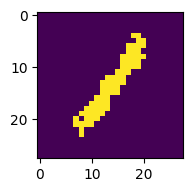

STEP: 2500 ELBO: -112.08519 recon_loss: -100.78534 kl: 17.834442


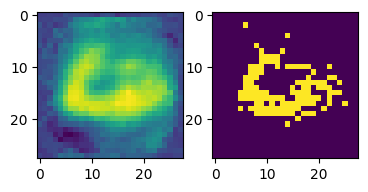

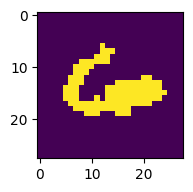

STEP: 2750 ELBO: -119.23186 recon_loss: -88.47566 kl: 17.565815


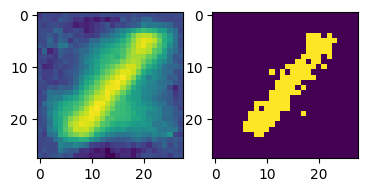

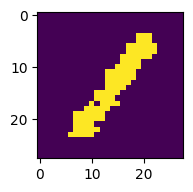

STEP: 3000 ELBO: -107.41661 recon_loss: -103.63545 kl: 17.950302


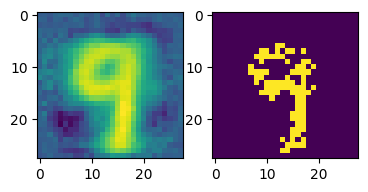

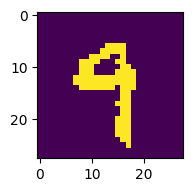

STEP: 3250 ELBO: -115.67792 recon_loss: -95.71152 kl: 17.751497


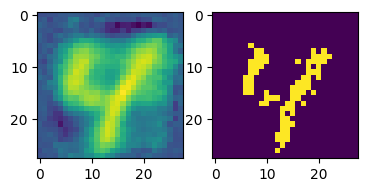

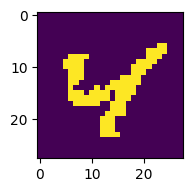

STEP: 3500 ELBO: -115.28372 recon_loss: -100.34418 kl: 17.227863


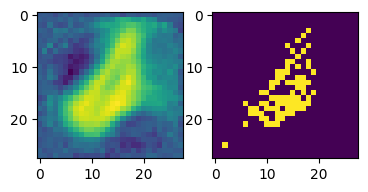

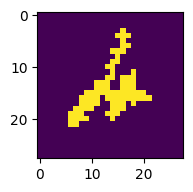

STEP: 3750 ELBO: -110.490036 recon_loss: -90.243904 kl: 16.829714


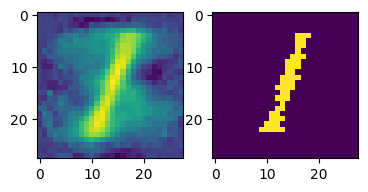

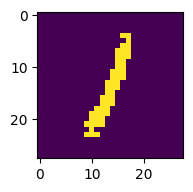

STEP: 4000 ELBO: -117.80802 recon_loss: -86.68291 kl: 17.629976


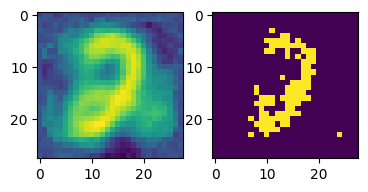

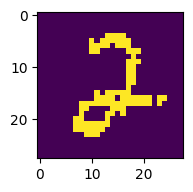

STEP: 4250 ELBO: -114.643196 recon_loss: -86.9318 kl: 17.348366


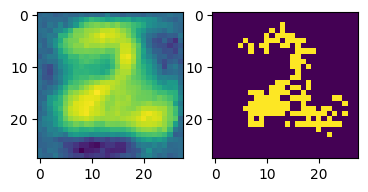

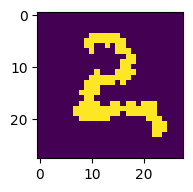

STEP: 4500 ELBO: -122.06825 recon_loss: -87.93617 kl: 18.285082


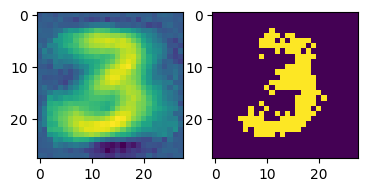

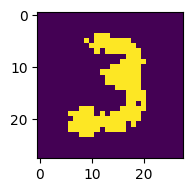

STEP: 4750 ELBO: -110.57765 recon_loss: -99.551735 kl: 18.76669


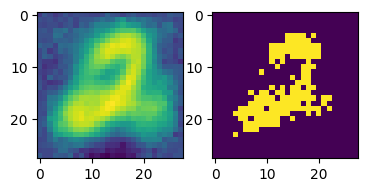

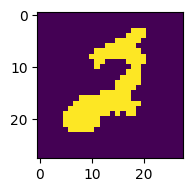

In [309]:
rng_seq = hk.PRNGSequence(random_seed)
params = model.init(next(rng_seq), np.zeros((1, *MNIST_IMAGE_SHAPE)))
opt_state = optimizer.init(params)

train_ds = load_dataset(tfds.Split.TRAIN, batch_size)
valid_ds = load_dataset(tfds.Split.TEST, batch_size)

elbo_values = []
recon_loss_values = []
kl_values = []


for step in range(training_steps):
  params, opt_state = update(
      params,
      next(rng_seq),
      opt_state,
      next(train_ds),
      )
  if step % 250 == 0:
    val_loss = loss_fn(params, next(rng_seq), next(valid_ds))
    recon_loss, kl = loss_fn2(params, next(rng_seq), next(valid_ds))

    elbo_values.append(val_loss)
    recon_loss_values.append(-recon_loss)
    kl_values.append(kl)
    print("STEP:", step, "ELBO:", -val_loss, "recon_loss:",recon_loss, "kl:", kl)
    a = next(valid_ds)['image']
    outputs: VAEOutput = model.apply(params, next(rng_seq),a)
    #print('image',outputs.image[0].shape)
    #print('logits',outputs.logits[0].shape)
    plt.subplot(1, 3, 1)
    plt.imshow(outputs.logits[0].squeeze())
    plt.subplot(1, 3, 2)
    plt.imshow(outputs.image[0].squeeze())
    plt.show()
    plt.subplot(1, 3, 3)
    plt.imshow(a[0].squeeze())
    plt.show()
    #plt.title('original image')

  #logging.info("STEP: %5d; Validation ELBO: %.3f", step, -val_loss)
  #print("STEP:", step, "ELBO:", -val_loss)

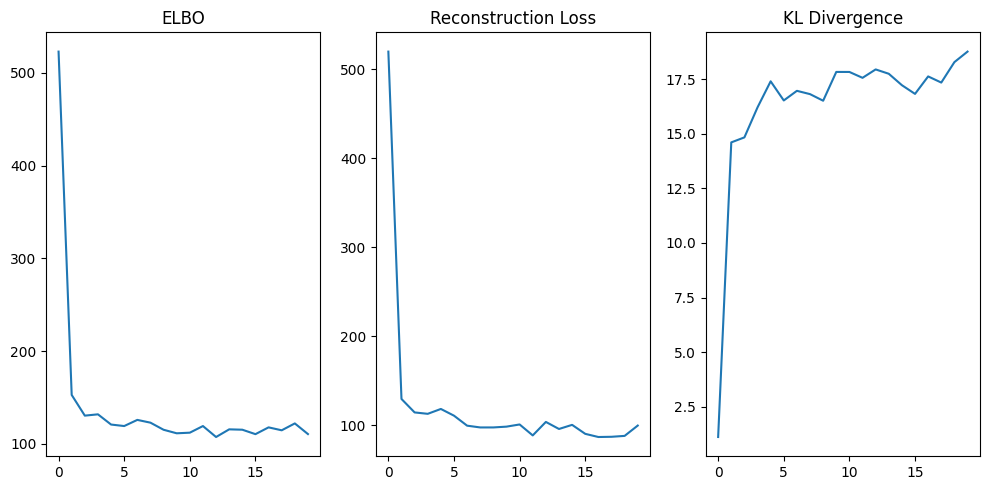

In [310]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.plot(elbo_values)
plt.title('ELBO')

plt.subplot(1, 3, 2)
plt.plot(recon_loss_values)
plt.title('Reconstruction Loss')

plt.subplot(1, 3, 3)
plt.plot(kl_values)
plt.title('KL Divergence')

plt.tight_layout()
plt.show()


# Missing data pre-processing


Random 50%

In [311]:
images = batch['image']
# Convert images to float type before introducing NaNs
images_float = images.astype(np.float32)

images_flat = images_float.reshape((images_float.shape[0], -1))  # Flatten each image

# Calculate the number of pixels to remove per image (50%)
num_pixels_to_remove = images_flat.shape[1] // 2

# Create a mask with 50% of the data points set to True (missing)
missing_mask = np.zeros_like(images_flat, dtype=bool)

for i in range(images_flat.shape[0]):
    missing_indices = np.random.choice(images_flat.shape[1], num_pixels_to_remove, replace=False)
    missing_mask[i, missing_indices] = True

# Apply the mask to create missing data
images_flat[missing_mask] = np.nan

# Reshape the data back to the original image shape
images_with_missing_data = images_flat.reshape(images_float.shape)

images_with_missing_data.shape


(32, 28, 28, 1)

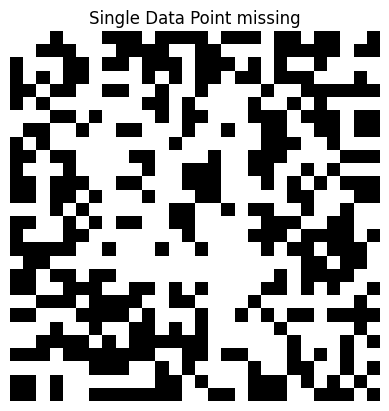

In [312]:
data_point_miss = images_with_missing_data[0]
plt.imshow(data_point_miss.squeeze(), cmap='gray')  # Use 'gray' for grayscale images
plt.title('Single Data Point missing')
plt.axis('off')
plt.show()

Only top half missing

In [313]:
images = batch['image']

# Convert images to float type before introducing NaNs
images_float = images.astype(np.float32)

# Directly remove the top half of each image
half_height = images_float.shape[1] // 2
images_with_top_half_missing = images_float.copy()
images_with_top_half_missing[:, :half_height, :, :] = np.nan

# The shape of the images_with_top_half_missing should be the same as the original batch
images_with_top_half_missing.shape

(32, 28, 28, 1)

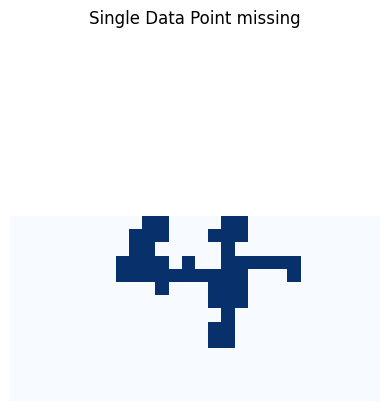

In [314]:
data_point_miss_half = images_with_top_half_missing[0]
plt.imshow(data_point_miss_half.squeeze(), cmap='Blues')  # Use 'blue' for indication with white?
plt.title('Single Data Point missing')
plt.axis('off')
plt.show()

# Get my trained model, encoder and decoder respectively


In [315]:
#Get my masks:

mask_missing = np.isnan(images_with_top_half_missing)
#mask_missing
mask_observed = ~mask_missing

In [316]:
images_with_top_half_missing[:, :half_height, :, :] = 0
images_refill = images_with_top_half_missing

In [317]:
rng_seq = hk.PRNGSequence(random_seed)
rng_miss = next(rng_seq)

trained_params = params
outputs: VAEOutput = model.apply(params, rng_miss, images_refill)
#my posterior distrubution
#outputs.mean,outputs.stddev,


In [318]:
trained_params.keys()

dict_keys(['variational_auto_encoder/decoder/linear', 'variational_auto_encoder/decoder/linear_1', 'variational_auto_encoder/encoder/linear', 'variational_auto_encoder/encoder/linear_1', 'variational_auto_encoder/encoder/linear_2'])

In [319]:
encoder_params = {k: v for k, v in trained_params.items() if '/encoder/' in k}
decoder_params = {k: v for k, v in trained_params.items() if 'decoder' in k}

#encoder_params.keys(), decoder_params.keys()

In [320]:
#encoder_params.keys()
new_encoder_params = {key.replace('variational_auto_encoder/', ''): value for key, value in encoder_params.items()}
#new_encoder_params

In [321]:
new_decoder_params = {key.replace('variational_auto_encoder/', ''): value for key, value in decoder_params.items()}
#new_decoder_params

# Acquiring


Posterior

In [322]:
encoder = hk.transform(lambda x: Encoder(512,10)(x))
mean, log_var = encoder.apply(new_encoder_params, rng_miss, images_refill)
decoder = hk.transform(lambda x: Decoder(512, MNIST_IMAGE_SHAPE)(x))

In [323]:
outputs.logits.shape

(32, 28, 28, 1)

In [324]:
#full datum
batch["image"].shape

(32, 28, 28, 1)

In [325]:
log_likelihood = -binary_cross_entropy(batch["image"], outputs.logits)
#shape 32 for a batch with 32 points
log_likelihood

Array([-165.82593 , -284.44113 ,  -96.61904 , -121.041534,  -99.31812 ,
       -251.81042 , -234.85617 , -218.26767 ,  -82.69792 , -175.08832 ,
       -128.94106 , -206.19264 , -299.42477 , -430.77625 , -164.57367 ,
       -147.25336 , -224.86461 , -200.9397  , -211.00052 , -291.25085 ,
       -271.23553 , -114.20936 ,  -57.990158, -196.3662  , -227.72263 ,
       -305.56125 , -179.98643 , -147.80344 , -122.0871  , -277.7895  ,
       -178.14383 , -157.70409 ], dtype=float32)

Sample_a_batch

In [51]:
# def sample_a_batch(Nz, Nx, rng):
#   res = []
#   for i in range(batch_size):
#     random = jax.random.normal(rng, (Nz, 10 ))
#     sampled_z_points = mean[i] + log_var[i] * random
#     output_x = decoder.apply(new_decoder_params, rng,sampled_z_points)
#     images = [] #expected to have Nz*Nx size
#     for decoded in output_x:
#       p = jax.nn.sigmoid(decoded)
#       for _ in range(Nx):
#         img = jax.random.bernoulli(rng_miss, p)
#         images.append(img)
#     images = jnp.array(images)

#   res.append(images)
#   return images


In [48]:
output_batch = sample_a_batch(200, 20, rng_miss)

In [ ]:
#output_batch = jnp.array(output_batch)
output_batch.shape

# Demo_datum


In [326]:
def sample_a_image(Nz, Nx, i, rng):
  random = jax.random.normal(rng, (Nz, 10 ))
  sampled_z_points = mean[i] + log_var[i] * random
  output_x = decoder.apply(new_decoder_params, rng,sampled_z_points)
  images = [] #expected to have Nz*Nx size
  for decoded in output_x:
    p = jax.nn.sigmoid(decoded)
    for _ in range(Nx):
      img = jax.random.bernoulli(rng, p)
      images.append(img)
  images = jnp.array(images)
  return images

In [327]:
output = sample_a_image(200,20,0, rng_miss)

In [328]:
R = jnp.var(output, axis=0)

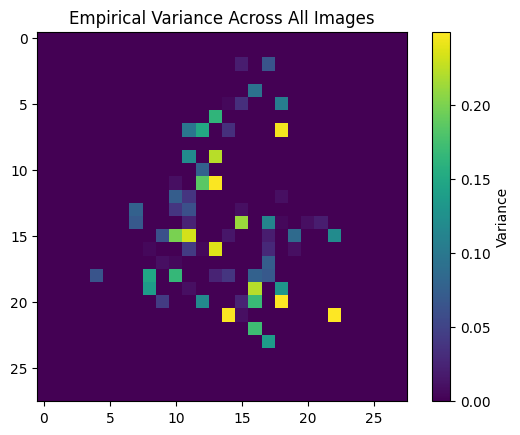

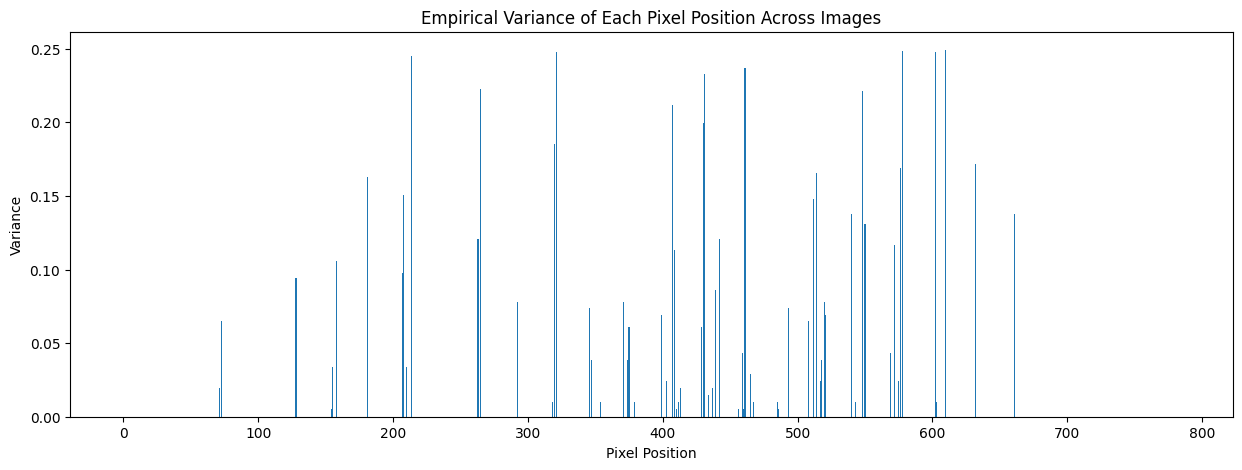

In [329]:
#variance = np.var(images, axis=0)

# Now we can visualize this as an image
plt.imshow(R, cmap='viridis')
plt.colorbar(label='Variance')
plt.title('Empirical Variance Across All Images')
plt.show()

# Flatten R to make a bar plot
R_flat = R.flatten()
plt.figure(figsize=(15, 5))
plt.bar(range(len(R_flat)), R_flat)
plt.title('Empirical Variance of Each Pixel Position Across Images')
plt.xlabel('Pixel Position')
plt.ylabel('Variance')
plt.show()

In [330]:
def get_next(index):
  R_masked = R * mask_missing[index].astype(R.dtype)
  i = jnp.argmax(R_masked)
  i_2d = jnp.unravel_index(i, (28,28))
  i = (i_2d[0].item(), i_2d[1].item())
  mask_observed[index][i] = True
  images_with_top_half_missing[index][i] = True
  return images_with_top_half_missing[index]

In [76]:
# R_masked = R * mask_missing[0].astype(R.dtype)
# i = jnp.argmax(R_masked)
# i_2d = jnp.unravel_index(i, (28,28))

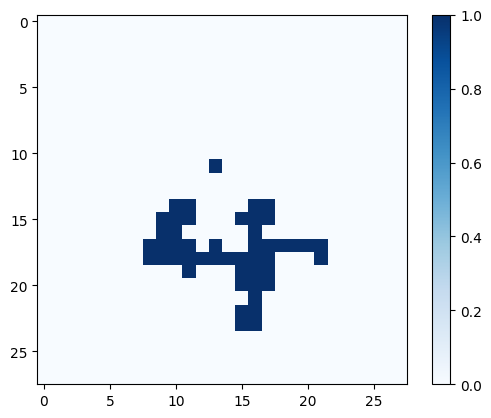

In [331]:
plt.imshow(get_next(0), cmap='Blues', vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Repeating

In [332]:
mask_missing[0] =~mask_observed[0]

In [333]:
np.sum(mask_observed[0]),np.sum(mask_missing[0])

(393, 391)

In [334]:
missing_mask = np.zeros_like(images_flat, dtype=bool)
missing_mask.shape

(32, 784)

In [335]:
images = batch['image']
# Convert images to float type before introducing NaNs
images_float = images.astype(np.float32)

images_flat = images_float.reshape((images_float.shape[0], -1))  # Flatten each image

# # Calculate the number of pixels to remove per image (50%)
# num_pixels_to_remove = images_flat.shape[1] // 2

# # Create a mask with 50% of the data points set to True (missing)
missing_mask = np.zeros_like(images_flat, dtype=bool)

for i in range(images_flat.shape[0]):
    #missing_indices = np.random.choice(images_flat.shape[1], num_pixels_to_remove, replace=False)
    #missing_mask[i, missing_indices] = True
    mask_missing[i] =~mask_observed[i]
    #update_image(i)

mask_missing = mask_missing.reshape(missing_mask.shape)
# Apply the mask to create missing data
images_flat[mask_missing] = np.nan

# Reshape the data back to the original image shape
images_with_missing_data = images_flat.reshape(images_float.shape)

images_with_missing_data.shape

(32, 28, 28, 1)